In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from omegaconf import OmegaConf
import collections

In [2]:
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
import os

In [4]:
import collections

def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [5]:
def value_rescale(x, eps=1.0e-3):
    return np.sign(x) * (np.sqrt(np.abs(x) + 1.0) - 1.0) + eps * x

In [6]:
MultirunResult = collections.namedtuple("MultirunResult", "name, ts_train, ts_eval, overrides, configs")


def load_dir(directory):
    directory = directory.rstrip("/") + "/"
    runs = sorted(os.listdir(directory))
    runs = [run for run in runs if "." not in run]

    dfs = {}
    dfs_eval = {}
    overrides = {}
    configs = {}
    for run in runs:
        f_eval = directory + run + "/eval.csv"
        f_train = directory + run + "/train.csv"    
        f_config = directory + run + "/.hydra/config.yaml"    
        f_override = directory + run + "/.hydra/overrides.yaml"    
        dfs[run] = pd.read_csv(f_train).set_index("timestep")
        dfs_eval[run] = pd.read_csv(f_eval).set_index("timestep")
        try:
            with open(f_override) as file:
                overrides[run] = yaml.load(file, Loader=yaml.FullLoader)
        except FileNotFoundError:
            overrides[run] = {}
        try:
            configs[run] = OmegaConf.load(f_config)
        except FileNotFoundError:
            configs[run] = {}
    
    result = MultirunResult(
        name=directory.split("/")[-2],
        ts_train=dfs,
        ts_eval=dfs_eval,
        overrides=overrides,
        configs=configs
    )
    
    return result

In [7]:
def compare_mrs(mrs, col="episode_reward", show_std=False, window=10, train=True):
    colors = sns.color_palette(n_colors=len(mrs))
    ax = None
    for mr, color in zip(mrs, colors):
        if train:
            joined = pd.concat(mr.ts_train.values(), axis=1)[[col]].loc[10000:]
        else:
            joined = pd.concat(mr.ts_eval.values(), axis=1)[[col]].loc[5000:]
#             window = 3
#         joined = joined.fillna(method="ffill")
        mean = joined.mean(axis=1).rolling(window).mean()
        std = joined.std(axis=1).rolling(window).mean()
        ax = mean.plot(ax=ax, c=color, label=mr.name, figsize=(10,5))
        if show_std:
            ax = (mean+std).plot(ax=ax, c=color, alpha=0.5, figsize=(10,5))
            ax = (mean-std).plot(ax=ax, c=color, alpha=0.5, figsize=(10,5))
    plt.legend()
    plt.title(col)

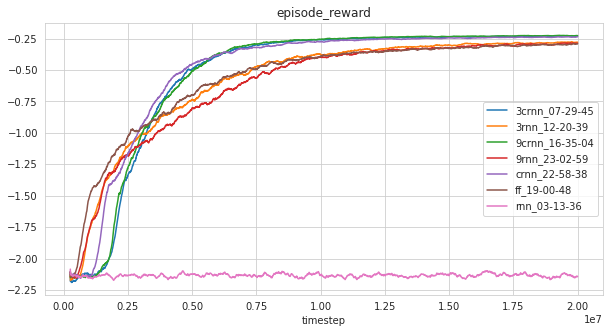

In [9]:
# path = "/home/ira/code/projects/rl_trickery/multirun/0_baselines//"
# path = "/home/ira/code/projects/rl_trickery/multirun/0_compare//"
# path = "/home/ira/code/projects/rl_trickery/multirun/0_baselines/m11fixed///"
path = "/home/ira/code/projects/rl_trickery/multirun/000_proper_experiments/m15/"
# path = "/home/ira/code/projects/rl_trickery/multirun/2020-07-12//"
dirs = os.listdir(path)
dirs = sorted(dirs)
mrs = [load_dir(path+dir_) for dir_ in dirs]
compare_mrs(mrs, col="episode_reward", show_std=False, window=200, train=True)

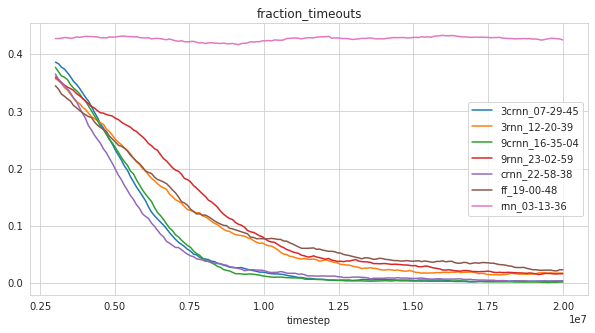

In [10]:
compare_mrs(mrs, col="fraction_timeouts", train=False, window=30)

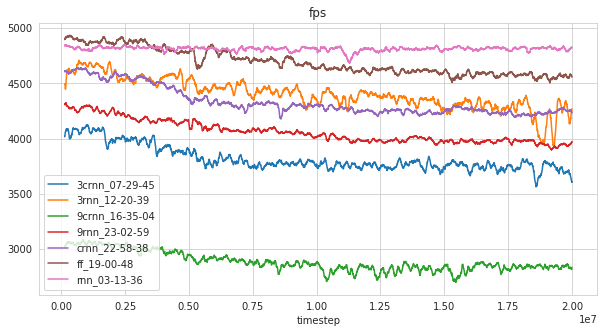

In [122]:
compare_mrs(mrs, col="fps", window=100)

In [11]:
# DIR = "/home/ira/code/projects/rl_trickery/multirun/0_compare/17-35-25_m9_baseline_crnn/"
# DIR = "/home/ira/code/projects/rl_trickery/multirun/0_baselines/mazelab/m11fixed_crnn/"
DIR = "/home/ira/code/projects/rl_trickery/multirun/2020-06-24/m9_rnn_2am_18-40-04//"

mr = load_dir(DIR)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ira/code/projects/rl_trickery/multirun/2020-06-24/m9_rnn_2am_18-40-04/'

In [ ]:
scores = {}
for run, ts in mr.ts_train.items():
#     scores[run] = -dfs_eval[run]["fraction_timeouts"][-10:].mean()
    scores[run] = ts["episode_reward"][0:].mean()
scores = pd.Series(scores)
scores

In [ ]:
rows = {}
for key, arg in mr.overrides.items():
    row = {}
    if type(arg) is list:
        for s in arg:
            col, val = s.split("=")
            row[col] = val
        rows[key] = (pd.Series(row))
results = pd.DataFrame(rows)
results = results.append(scores.rename("score"))
results = results.T.sort_values("score", ascending=False)

In [ ]:
configs = {}
for key, config in mr.configs.items():
    configs[key] = flatten(config)
full_results = pd.DataFrame(configs).append(scores.rename("score")).T.sort_values("score", ascending=False)

In [ ]:
ax = None

target_vars = [
    "episode_reward",
    "fraction_timeouts",
]

top_q = 0.0
y_lim = None

for target_var in target_vars:
    ax = None
    for key, df in mr.ts_eval.items():
        if scores[key] < scores.quantile(top_q):
            continue
        if target_var in df.columns:
            df = df[target_var]
            df = df.rolling(5).mean()
#             df = value_rescale(df)
            ax = df.reset_index().plot(x="timestep", y=target_var, label=key, ax=ax, figsize=(10,5), ylim=y_lim)
#             ax = df.reset_index().plot(x="timestep", y=target_var, label=key, ax=ax, figsize=(10,5))
            plt.title(target_var)

In [ ]:
ax = None

target_vars = [
    "episode_reward",
    "loss_entropy",
    "act",
    "fps",
    "episode",
    "value",
]

top_q = 0.0
y_lim = None

for target_var in target_vars:
    ax = None
    for key, df in mr.ts_train.items():
        if scores[key] < scores.quantile(top_q):
            continue
        if target_var in df.columns:
            df = df[target_var]
            df = df.rolling(25).mean()
#             df = value_rescale(df)
            ax = df.reset_index().plot(x="timestep", y=target_var, label=key, ax=ax, figsize=(10,5), ylim=y_lim)
#             ax = df.reset_index().plot(x="timestep", y=target_var, label=key, ax=ax, figsize=(10,5))
            plt.title(target_var)

In [ ]:
results.score = results.score.map(float)

In [ ]:
results